# Digital Forensics Project: Generative Adversarial Network
## Generative Adversarial Network on FashionMNIST and DeepFashion Datasets
### Marchiori Francesco, ID: 2020389
### [DeepFashion Dataset](http://mmlab.ie.cuhk.edu.hk/projects/DeepFashion.html)

## Importing the libraries

Other than the basic libraries needed in Python, Tensorflow is used (with Keras as its backend) in order to implement the GAN.

In [1]:
import os
import pathlib
import time

import matplotlib.pyplot as plt
from IPython import display
import numpy as np

import tensorflow as tf
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras import models
from keras.utils.vis_utils import plot_model

### Value for the checkpoint

In [2]:
last_epoch = 1000

## Importing the Dataset

A subset of the [DeepFashion Dataset](http://mmlab.ie.cuhk.edu.hk/projects/DeepFashion.html) is imported. This dataset contains over 800,000 diverse fashion images ranging from well-posed shop images to unconstrained consumer photos, therefore in the directory from which images are taken only a subset of them are present, because the current machine on which the program is running doesn't have enough GPU memory to support them all. The images have various sizes and all of them have 3 channels for RGB, but in the processing they will be resized to a 64x64 image size. Also the batch size is reduced to 128 with respect to the previous model, for the reason stated before about GPU memory.

In [3]:
dataset_directory = "./DeepFashion/DeepFashion/Train/"
dataset_directory = pathlib.Path(dataset_directory)

num_elem_label = [1225, 849, 542, 846, 532, 648, 560, 299, 594, 927, 477, 378, 702, 378, 468]
labels_name = ['Blazer', 'Blouse', 'Cardigan', 'Dress', 'Jacket', 'Jeans', 'Jumpsuit', 'Romper', 'Shorts', 'Skirt', 'Sweater', 'Sweatpants', 'Tank', 'Tee', 'Top']
labels = []

for i in range(15):
    j = num_elem_label[i]
    while j > 0:
        labels.append(i)
        j = j - 1


images_ds = tf.data.Dataset.list_files(os.path.join(dataset_directory, '*/*'),shuffle=False)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(dataset_directory,
    labels='inferred',
    shuffle=False,
    image_size=(64, 64),
    batch_size=128)

print('Shape of the dataset:', train_ds)

Found 9425 files belonging to 15 classes.
Shape of the dataset: <BatchDataset shapes: ((None, 64, 64, 3), (None,)), types: (tf.float32, tf.int32)>


### Dataset Plot

Some example is generated in order to show what the dataset looks like.

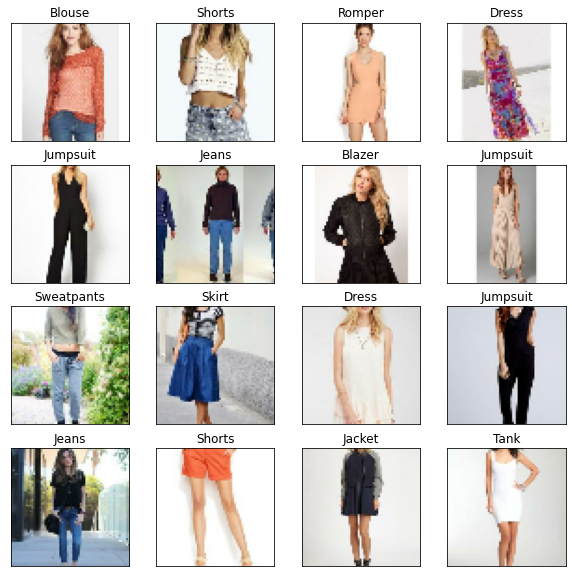

In [4]:
# Print processed images of random images

IMG_CHANNELS = 3
IMG_HEIGHT = 64
IMG_WIDTH = 64

plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    for path in images_ds.shuffle(buffer_size=9425).take(1):
        name = tf.strings.split(path, os.path.sep)
        name = name[3].numpy().decode("utf-8")
        image = tf.io.read_file(path)
        image = tf.image.decode_png(image, channels=IMG_CHANNELS)
        image = tf.keras.preprocessing.image.smart_resize(image, (IMG_HEIGHT, IMG_WIDTH))
        plt.title(name)
        plt.imshow(image.numpy().astype('uint8'))

plt.show()

### Creation and normalization of the dataset

Starting from *train_ds*, a dataset with batches of size 128 is created.

In [5]:
BUFFER_SIZE = 9425
BATCH_SIZE = 256

normalized_ds = train_ds.map(lambda image, label: ((image - 127.5) / 127.5, label))

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

## cGAN Model

In the following section the definitions of the generator and discriminator of the model are presented. Since the dataset is composed by images and labels, the prevalent layer type will be the Convolutional Layer which makes these models Convolutional Neural Network, machine learning models particularly suited for the processing of images. However, since there are also labels in the dataset, the models will take in input both the image and the label, therefore a `Concatenate` layer will be necessary in order to merge the values coming from the two different inputs.

### Generator Model

The generator takes in input some random noise and a label and returns in output a 64x64 image (with pixel value $\in [-1, 1]$ as the images in the dataset). The label passes through an `Embedding` layer which maps it to a 100 element vector and passes through a `Dense` layer before getting reshaped in order to match the size of the seed of the image, which in turn gets processed as a 16x16 image with 128 channels. Therefore, in the `Concatenate` layer the label and the image are merged in a single 16x16 image with 129 channels (with the last one being the one coming from the label). After that, a similar processing as the standard GAN is done.

In [6]:
def generator_model():
	"""
	Defines the generator model for the GAN using TensorFlow layers.
	
	INPUT: random noise
	OUTPUT: 64x64 RGB image with pixel value between -1 and 1
	"""

	# Label Input
	label = layers.Input(shape=(1,), name='Label_Input')
	# Embedding layer: takes the 10 possible labels and maps them in a vector of size 100
	embedding = layers.Embedding(input_dim=15, output_dim=100, name='Embedding')(label)
	# Dense layer
	dense_label = layers.Dense(16*16, name='Dense_Label')(embedding)
	# Reshape
	reshape_label = layers.Reshape((16, 16, 1), name='Reshape_Label')(dense_label)

	# Image Generator Input
	image_gen = layers.Input(shape=(100,), name='Image_Seed_Input')
	# Pre-processing
	dense_img = layers.Dense(16*16*128, name='Dense_Img')(image_gen)
	batch_norm = layers.BatchNormalization(name='Batch_Normalization')(dense_img)
	act = layers.LeakyReLU(name='Leaky_ReLU_Img')(batch_norm)
	reshape_img = layers.Reshape((16, 16, 128), name='Reshape_Img')(act)

	# Concatenation of label and image
	merge = layers.Concatenate(name='Concatenate')([reshape_img, reshape_label])

	# Then, a similar model to the previously presented GAN is built
	# First Upsampling
	x = layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', name='Conv2DT_1')(merge)
	x = layers.LeakyReLU(name='Leaky_ReLU_1')(x)

	# Second Upsampling
	x = layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', name='Conv2DT_2')(x)
	x = layers.LeakyReLU(name='Leaky_ReLU_2')(x)

	# Output
	output = layers.Conv2D(3, (7, 7), activation='tanh', padding='same', name='Conv2D')(x)

	# Model definition
	return models.Model([image_gen, label], output, name='Generator')

In [7]:
# Create the generator model and prints a summary of its layers

generator = generator_model()
generator.summary()

Model: "Generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Image_Seed_Input (InputLayer)   [(None, 100)]        0                                            
__________________________________________________________________________________________________
Dense_Img (Dense)               (None, 32768)        3309568     Image_Seed_Input[0][0]           
__________________________________________________________________________________________________
Label_Input (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
Batch_Normalization (BatchNorma (None, 32768)        131072      Dense_Img[0][0]                  
__________________________________________________________________________________________

### Noise plots

Some examples are now generated by creating 16 instances of noise and, by taking them as input in the generator model, the output images are plotted.

Noise shape: (16, 64, 64, 3)


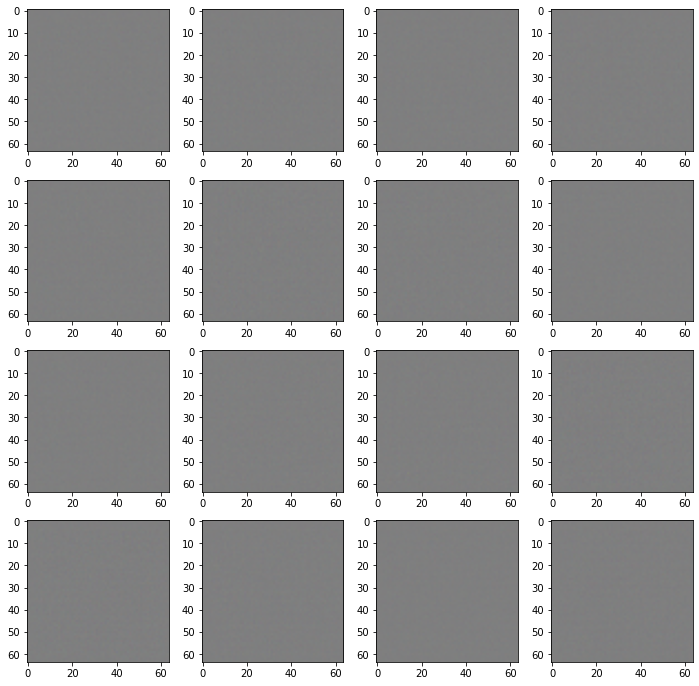

In [8]:
noise = tf.random.normal([16, 100])
generated_image = generator((noise, np.zeros(16)), training=False)

print('Noise shape:', generated_image.shape)

plt.figure(figsize=(12, 12))

for i in range(16):
    
    generated_unnorm = (generated_image[i] * 127.5 + 127.5).numpy()
    plt.subplot(4, 4, i + 1)
    plt.imshow(generated_unnorm.astype('uint8'))

## Discriminator Model

The discriminator takes in input some some 64x64 images (with pixel value $\in [-1, 1]$) and a label and returns in output a value between 0 and 1. This output represent the prediction of the discriminator of the image taken in input, where 0 means that the image is fake and 1 means that the image is real. As the generator, it uses and `Embedding` layer to map the label to a 100 element vector and process it by reshaping it accordingly. It then uses the `Concatenate` layer and the processing done after that is similar to the one saw in the standard GAN discriminator.

In [9]:
def discriminator_model():
	"""
	Defines the discriminator model for the GAN using TensorFlow layers.
	
	INPUT: 64x64 RGB image with pixel value between -1 and 1
	OUTPUT: value between 0 and 1 (0 = fake image, 1 = real image)
	"""

	# Label Input
	label = layers.Input(shape=(1,), name='Label_Input')
	# Embedding layer: takes the 10 possible labels and maps them in a vector of size 100
	embedding = layers.Embedding(input_dim=15, output_dim=100, name='Embedding')(label)
	# Dense layer
	dense_label = layers.Dense(64*64, name='Dense_Label')(embedding)
	# Reshape
	reshape_label = layers.Reshape((64, 64, 1), name='Reshape_Label')(dense_label)

	# Image Input
	image = layers.Input(shape=(64, 64, 3), name='Image_Input')

	# Concatenation of label and image
	merge = layers.Concatenate(name='Concatenate')([image, reshape_label])

	# Then, a similar model to the previously presented GAN is built
	# First Downsampling
	x = layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same', name='Conv2DT_1')(merge)
	x = layers.LeakyReLU(name='Leaky_ReLU_1')(x)
	# Second Downsampling
	x = layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same', name='Conv2DT_2')(x)
	x = layers.LeakyReLU(name='Leaky_ReLU_2')(x)
	# Flatten feature maps
	x = layers.Flatten(name='Flatten')(x)
	# Dropout
	x = layers.Dropout(0.3, name='Dropout')(x)
	# Output
	output = layers.Dense(1, activation='sigmoid', name='Sigmoid')(x)

	# Model definition
	return models.Model([image, label], output, name='Discriminator')

In [10]:
discriminator = discriminator_model()
discriminator.summary()

Model: "Discriminator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Label_Input (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
Embedding (Embedding)           (None, 1, 100)       1500        Label_Input[0][0]                
__________________________________________________________________________________________________
Dense_Label (Dense)             (None, 1, 4096)      413696      Embedding[0][0]                  
__________________________________________________________________________________________________
Image_Input (InputLayer)        [(None, 64, 64, 3)]  0                                            
______________________________________________________________________________________

## Loss and Optimization

In order to train the model, it's now important to define its loss and its optimizers

In [11]:
# Set the cross entropy

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [12]:
def generator_loss(fake_output):
    """ Function for the calculation of the generator loss """
    
    gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    return gen_loss

In [13]:
def discriminator_loss(real_output, fake_output):
    """ Function for the calculation of the discriminator loss """

    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)

    return real_loss + fake_loss

In [14]:
# Setting up the optimizers for the models

generator_optimizer = tf.keras.optimizers.Adam(lr=0.0001)
discriminator_optimizer = tf.keras.optimizers.Adam(lr=0.0001)

In [15]:
# Arrays for the losses

g_loss = []
d_loss = []

if last_epoch > 1:
    with open(os.path.join('./Losses/', 'losses_cdf_1.csv'), 'r') as fp:
        g_loss += [float(i) for i in fp.readline().rstrip().split(",")]
        d_loss += [float(i) for i in fp.readline().rstrip().split(",")]

### Checkpoints

In [16]:
checkpoint_dir = './Checkpoints_cDF'
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                  discriminator_optimizer=discriminator_optimizer,
                                  generator=generator,
                                  discriminator=discriminator)

generator_path = os.path.join(checkpoint_dir, 'generator')
discriminator_path = os.path.join(checkpoint_dir, 'discriminator')
                              
checkpoint_manager = tf.train.CheckpointManager(
    checkpoint,
    directory=checkpoint_dir,
    max_to_keep=1,
    checkpoint_name="ckpt")

In [17]:
if last_epoch > 1:
    checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Training

It's now time to train the model. However, to do so it's necessary to define the number of epochs, the noise dimension and thoroughly define the training procedure.

In [18]:
EPOCHS = 1500
noise_dim = 100
num_examples_to_generate = 30

images_seed = tf.random.normal([num_examples_to_generate, noise_dim])
labels_seed = np.array([])

for i in range(15):
    j = 2
    while j > 0:
        labels_seed = np.append(labels_seed, i)
        j = j - 1
        
print(labels_seed)

[ 0.  0.  1.  1.  2.  2.  3.  3.  4.  4.  5.  5.  6.  6.  7.  7.  8.  8.
  9.  9. 10. 10. 11. 11. 12. 12. 13. 13. 14. 14.]


In [19]:
@tf.function
def train_step(images, labels):
  """ Function for the definition of a train step """

  # Generate the noise
  noise = tf.random.normal([images.shape[0], noise_dim])

    # Generate the images from the noise with the generator
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator((noise, labels), training=True)

      # Give in input to the discriminator both the real and the fake images
    real_output = discriminator((images, labels), training=True)
    fake_output = discriminator((generated_images, labels), training=True)

      # Compute the losses for generator and discriminator
    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

    # Compute the gradients for generator and discriminator
  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Apply learned gradients
  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

  return gen_loss, disc_loss

In [20]:
def generate_and_save_images(model, epoch, test_input, label_input):
  """ Function for the generation and saving the images """

  predictions = model((test_input, label_input), training=False)

  fig = plt.figure(figsize=(15, 18))

  for i in range(predictions.shape[0]):
      plt.subplot(5, 6, i + 1)
      plt.title(labels_name[int(label_input[i])])
      plt.imshow((predictions[i] * 127.5 + 127.5).numpy().astype('uint8'))
      plt.axis('off')

  plt.savefig('./Images/Epoch_{:04d}.png'.format(epoch))
  plt.show()

In [21]:
def train(dataset, epochs):
  """ Defines all the actions that are done during training """

  for epoch in range(epochs - last_epoch + 1):
    start = time.time()

    epoch = epoch + last_epoch

    for image_batch, label_batch in dataset:
      gen_loss, disc_loss = train_step(image_batch, label_batch)

    # Save losses of the epoch
    g_loss.append(gen_loss.numpy())
    d_loss.append(disc_loss.numpy())

    # Clear output
    display.clear_output(wait=True)

    # Print losses
    print('Generator loss: {}\nDiscriminator loss: {}'.format(gen_loss.numpy(), disc_loss.numpy()))

    # Produce images
    generate_and_save_images(generator, epoch, images_seed, labels_seed)
    print ('Time for epoch {} is {} sec'.format(epoch, time.time()-start))

    # Save the model every 20 epochs
    if epoch % 20 == 0 or epoch == 1:
      checkpoint_manager.save()

      print('Saved checkpoint of epoch #{}'.format(epoch))

      # Save losses
      with open(os.path.join('./Losses/', 'losses_cdf_1.csv'), 'w') as fp:
        fp.writelines(','.join([str(i) for i in g_loss]))
        fp.writelines('\n')
        fp.writelines(','.join([str(i) for i in d_loss]))
        fp.writelines('\n')

  # Generate after the final epoch
  display.clear_output(wait=True)

  generate_and_save_images(generator, epochs, images_seed, labels_seed)

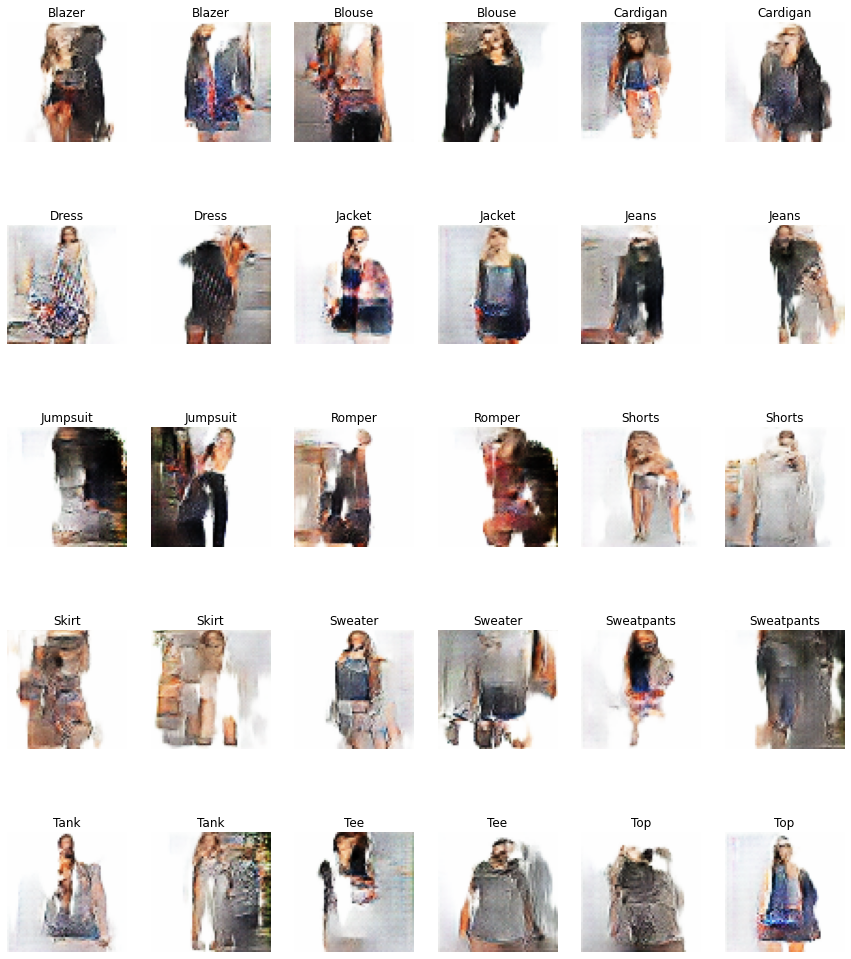

In [22]:
train(normalized_ds, EPOCHS)

## Losses Plots

Generate the plot of the losses for both the generator and the discriminator.

In [23]:
def plot_losses(losses, title):
    """ Plots the losses given in input """

    epochs = len(losses)

    plt.figure(figsize=(20, 10))
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.plot(losses)
    plt.savefig('./Losses/' + title + '_cDF_GAN.png', bbox_inches='tight')
    plt.show()

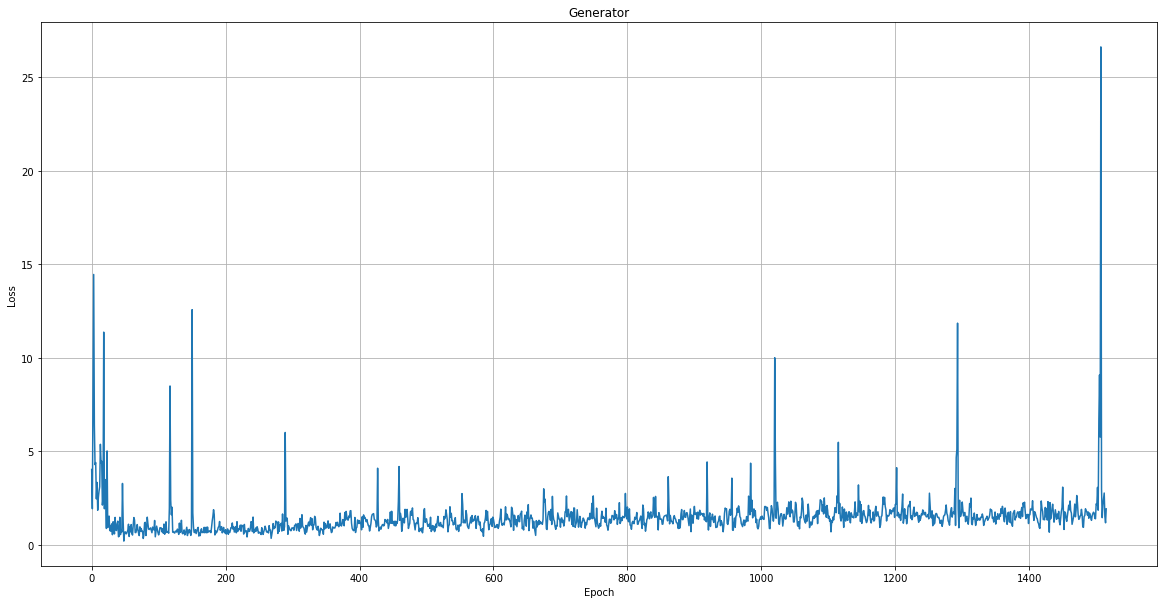

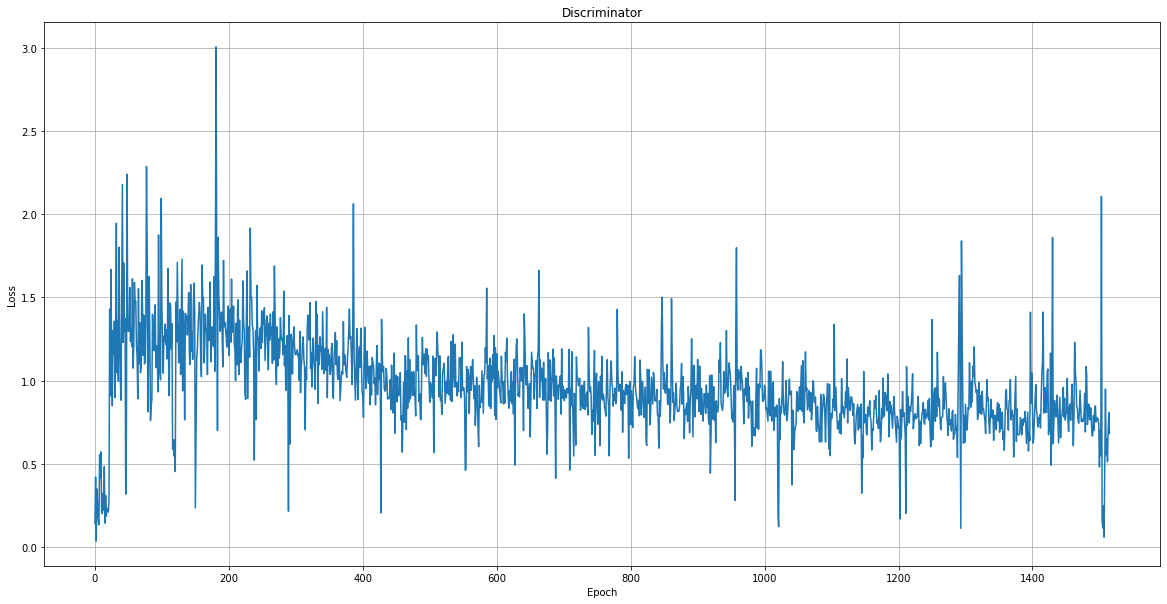

In [24]:
plot_losses(g_loss, 'Generator')
plot_losses(d_loss, 'Discriminator')